In [1]:
import numpy as np
import pandas as pd
from scipy.signal import stft
import pywt

print("Libraries imported")



Libraries imported


In [3]:
DATA_PATH = "../Data/processed/biomedical_preprocessed.csv"
combined_df = pd.read_csv(DATA_PATH)

print("Loaded combined_df shape:", combined_df.shape)
combined_df.head()


MemoryError: Unable to allocate 256. KiB for an array with shape (32768,) and data type int64

In [9]:
FS = 500              # Sampling frequency
WINDOW_SEC = 5
WINDOW_SIZE = FS * WINDOW_SEC
STEP_SIZE = WINDOW_SIZE // 2

# STFT parameters (reduced size to avoid MemoryError)
N_PER_SEG = 256
N_OVERLAP = 128

# CWT parameters (LIMITED scales)
CWT_SCALES = np.arange(1, 33)   # VERY IMPORTANT
WAVELET = "morl"

print("Parameters set")


Parameters set


In [10]:
#stft features
def stft_features(signal, fs):
    """
    Extract numerical STFT features
    """
    f, t, Zxx = stft(
        signal,
        fs=fs,
        nperseg=N_PER_SEG,
        noverlap=N_OVERLAP
    )

    power = np.abs(Zxx) ** 2

    return {
        "stft_mean_power": np.mean(power),
        "stft_std_power": np.std(power),
        "stft_max_power": np.max(power)
    }


def cwt_features(signal, fs):
    """
    Extract numerical CWT features
    """
    coeffs, freqs = pywt.cwt(
        signal,
        scales=CWT_SCALES,
        wavelet=WAVELET,
        sampling_period=1/fs
    )

    energy = np.abs(coeffs) ** 2

    return {
        "cwt_mean_energy": np.mean(energy),
        "cwt_std_energy": np.std(energy),
        "cwt_max_energy": np.max(energy)
    }


In [11]:
tf_features = []

for (subject, activity), group in combined_df.groupby(["subject_id", "activity"]):

    group = group.sort_values("time")

    ax = group["a_x"].values
    ay = group["a_y"].values
    az = group["a_z"].values

    min_len = min(len(ax), len(ay), len(az))

    for start in range(0, min_len - WINDOW_SIZE + 1, STEP_SIZE):
        end = start + WINDOW_SIZE

        ax_w = ax[start:end]
        ay_w = ay[start:end]
        az_w = az[start:end]

        # STFT features
        stft_ax = stft_features(ax_w, FS)
        stft_ay = stft_features(ay_w, FS)
        stft_az = stft_features(az_w, FS)

        # CWT features
        cwt_ax = cwt_features(ax_w, FS)
        cwt_ay = cwt_features(ay_w, FS)
        cwt_az = cwt_features(az_w, FS)

        tf_features.append({
            "subject_id": subject,
            "activity": activity,

            # STFT
            "ax_stft_mean": stft_ax["stft_mean_power"],
            "ay_stft_mean": stft_ay["stft_mean_power"],
            "az_stft_mean": stft_az["stft_mean_power"],

            "ax_stft_std": stft_ax["stft_std_power"],
            "ay_stft_std": stft_ay["stft_std_power"],
            "az_stft_std": stft_az["stft_std_power"],

            # CWT
            "ax_cwt_mean": cwt_ax["cwt_mean_energy"],
            "ay_cwt_mean": cwt_ay["cwt_mean_energy"],
            "az_cwt_mean": cwt_az["cwt_mean_energy"],

            "ax_cwt_std": cwt_ax["cwt_std_energy"],
            "ay_cwt_std": cwt_ay["cwt_std_energy"],
            "az_cwt_std": cwt_az["cwt_std_energy"]
        })

print("Time-frequency feature extraction completed")


Time-frequency feature extraction completed


In [13]:
acc_timefreq_features = pd.DataFrame(tf_features)

print("ACC time-frequency features shape:", acc_timefreq_features.shape)
acc_timefreq_features.tail()


ACC time-frequency features shape: (1158, 14)


,subject_id,activity,ax_stft_mean,ay_stft_mean,az_stft_mean,ax_stft_std,ay_stft_std,az_stft_std,ax_cwt_mean,ay_cwt_mean,az_cwt_mean,ax_cwt_std,ay_cwt_std,az_cwt_std
1153,s22,walk,0.873099,0.024277,0.026301,8.384508,0.240280,0.299226,0.478987,0.060704,0.055157,4.788565,0.227008,0.196842
1154,s22,walk,0.884580,0.026680,0.028913,8.471567,0.348639,0.302052,0.567509,0.094083,0.100193,5.705455,0.526408,0.413785
1155,s22,walk,0.863132,0.035641,0.030918,8.303811,0.425425,0.306901,0.582184,0.054727,0.129971,5.958103,0.165028,0.436473
1156,s22,walk,0.846556,0.040413,0.030718,8.143792,0.416834,0.292606,0.584215,0.065065,0.158041,5.873052,0.218393,0.712339
1157,s22,walk,0.853862,0.034118,0.030795,8.176259,0.363041,0.302753,0.598542,0.077681,0.115517,5.982202,0.266560,0.523443


In [14]:
OUTPUT_PATH = "../Data/processed/acc_timefreq_features.csv"
acc_timefreq_features.to_csv(OUTPUT_PATH, index=False)

print("Saved:", OUTPUT_PATH)


Saved: ../Data/processed/acc_timefreq_features.csv


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.multivariate.manova import MANOVA

print("Libraries imported")


Libraries imported


In [16]:
DATA_PATH = "../Data/processed/acc_timefreq_features.csv"
acc_tf = pd.read_csv(DATA_PATH)

print("Loaded shape:", acc_tf.shape)
acc_tf.head()


Loaded shape: (1158, 14)


,subject_id,activity,ax_stft_mean,ay_stft_mean,az_stft_mean,ax_stft_std,ay_stft_std,az_stft_std,ax_cwt_mean,ay_cwt_mean,az_cwt_mean,ax_cwt_std,ay_cwt_std,az_cwt_std
0,s12,run,0.084780,0.194748,0.546120,0.871857,1.897379,5.268664,0.104376,0.207857,0.395728,0.415691,0.845011,3.284234
1,s12,run,0.067630,0.220075,0.545631,0.702104,2.119651,5.257753,0.135114,0.272594,0.497114,0.697873,1.123894,4.467649
2,s12,run,0.054747,0.226525,0.550240,0.585934,2.221784,5.309952,0.105297,0.267933,0.436328,0.353898,0.922514,3.498731
3,s12,run,0.053406,0.197046,0.590733,0.571140,1.978590,5.710879,0.091054,0.404219,0.490705,0.281206,2.069648,4.512103
4,s12,run,0.060428,0.149521,0.642421,0.625609,1.481699,6.179683,0.158510,0.303740,0.487766,0.745922,1.125218,3.767847


In [17]:
acc_tf["activity"].value_counts()


activity
run     386
sit     386
walk    386
Name: count, dtype: int64

In [18]:
manova_features = acc_tf[
    [
        "ax_stft_mean", "ay_stft_mean", "az_stft_mean",
        "ax_cwt_mean", "ay_cwt_mean", "az_cwt_mean"
    ]
]

manova_df = pd.concat(
    [manova_features, acc_tf["activity"]],
    axis=1
)

manova_df.head()


,ax_stft_mean,ay_stft_mean,az_stft_mean,ax_cwt_mean,ay_cwt_mean,az_cwt_mean,activity
0,0.084780,0.194748,0.546120,0.104376,0.207857,0.395728,run
1,0.067630,0.220075,0.545631,0.135114,0.272594,0.497114,run
2,0.054747,0.226525,0.550240,0.105297,0.267933,0.436328,run
3,0.053406,0.197046,0.590733,0.091054,0.404219,0.490705,run
4,0.060428,0.149521,0.642421,0.158510,0.303740,0.487766,run


In [19]:
maov = MANOVA.from_formula(
    "ax_stft_mean + ay_stft_mean + az_stft_mean + "
    "ax_cwt_mean + ay_cwt_mean + az_cwt_mean ~ activity",
    data=manova_df
)

print(maov.mv_test())


                     Multivariate linear model
                                                                   
-------------------------------------------------------------------
       Intercept         Value   Num DF   Den DF   F Value   Pr > F
-------------------------------------------------------------------
          Wilks' lambda   0.0046 6.0000 1150.0000 41642.3113 0.0000
         Pillai's trace   0.9954 6.0000 1150.0000 41642.3113 0.0000
 Hotelling-Lawley trace 217.2642 6.0000 1150.0000 41642.3113 0.0000
    Roy's greatest root 217.2642 6.0000 1150.0000 41642.3113 0.0000
-------------------------------------------------------------------
                                                                   
-------------------------------------------------------------------
         activity         Value   Num DF   Den DF   F Value  Pr > F
-------------------------------------------------------------------
           Wilks' lambda  0.0329 12.0000 2300.0000  865.0511 0.0000
 

In [20]:
example_subject = acc_tf["subject_id"].iloc[0]

activities = ["walk", "run", "sit"]


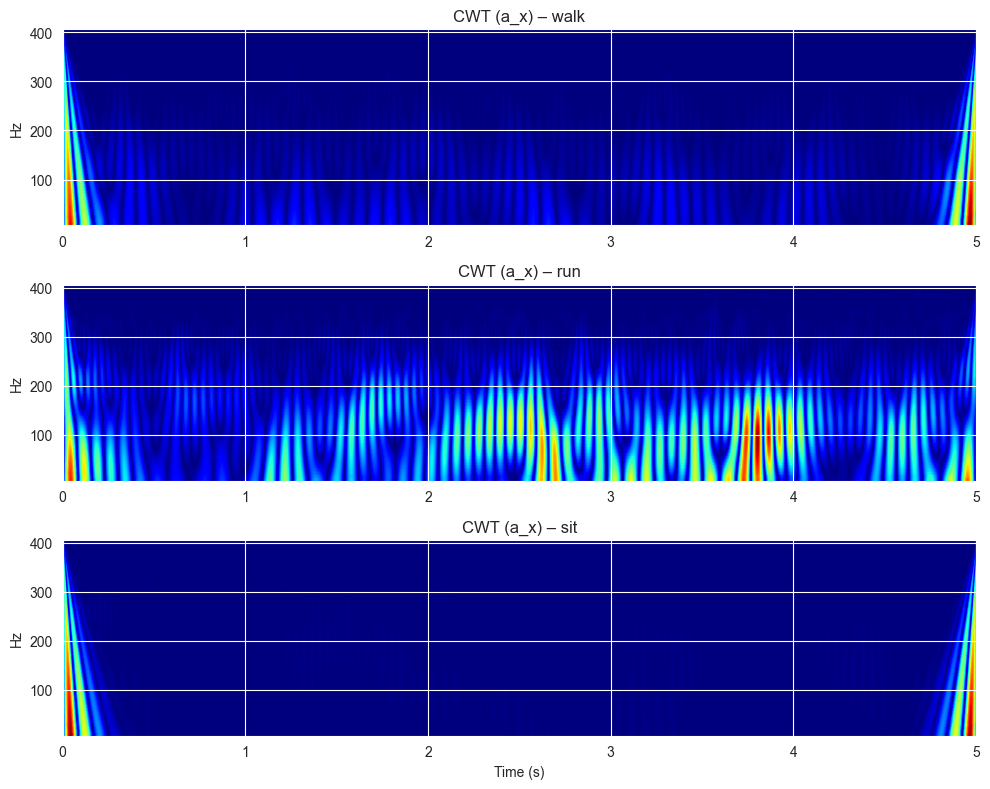

In [22]:
plt.figure(figsize=(10, 8))

scales = np.arange(1, 64)

for i, act in enumerate(activities, 1):

    subset = combined_df[
        (combined_df["subject_id"] == example_subject) &
        (combined_df["activity"] == act)
    ]

    ax = subset["a_x"].values[:FS*5]

    coeffs, freqs = pywt.cwt(
        ax, scales, "morl", sampling_period=1/FS
    )

    plt.subplot(3, 1, i)
    plt.imshow(
        np.abs(coeffs),
        extent=[0, len(ax)/FS, freqs[-1], freqs[0]],
        aspect="auto",
        cmap="jet"
    )
    plt.ylabel("Hz")
    plt.title(f"CWT (a_x) – {act}")

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()
